# クラスタリングで時系列予測はできる？(https://devblog.thebase.in/entry/2018/12/20/110000)

こんにちは。Data Strategy Group の岡です。趣味は珍しいお酒を飲むこと、将来の夢はウイスキーの蒸留所を持つことです。

私は機械学習エンジニアとしてまだ２年目なのですが、「この予測手法、本やweb上でほとんど見かけないな。」とずっと気になっている手法があります。ざっくり説明すると、時系列データをクラスタリングして同クラスタ内の平均を予測に使う、というもので、私より20くらい歳上の分析屋に教えてもらいました。下記の論文が一番これに近いと思います。

[Time Series Forecasting through Clustering - A Case Study](https://users.cs.duke.edu/~vamsi/papers/clustering.pdf)

今回は実験も兼ねてその予測手法を再現しようと思います。

## 使用データ
---
そういえば、昨日は@Toshi_Day1のFintechについての記事があり、先日の河越の鶴岡さん観察日記ではジャック・ドーシー氏の話題があったので、この流れでTwitterの株価を予測してみましょう。

ナスダックのサイトから５年分の日次株価データをダウンロードしました。

ここから直近30日分を検証データとして切り出し、それ以前のデータを学習データとして使います。

In [73]:
#!/usr/bin/env python3

# モジュール
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pylab as plt

# 読み込み & 日付でソート
twtr_stock = pd.read_csv('../00.data/HistoricalQuotes.csv').sort_values('date').reset_index(drop=True)

# 末尾30件を検証データとして分割
train_df = twtr_stock[0:-30].reset_index(drop=True)
test_df = twtr_stock[-30:].reset_index(drop=True)

In [74]:
train_df

,date,close,volume,open,high,low
0,2015/10/1,24.68,30871810,26.47,26.840,24.65
1,2015/10/12,28.75,30550190,30.30,30.770,28.60
2,2015/10/13,29.06,45741690,29.55,30.680,28.84
3,2015/10/14,29.38,27502160,29.46,29.820,28.38
4,2015/10/15,29.71,15799210,29.46,30.280,29.01
...,...,...,...,...,...,...
1224,2020/2/28,33.20,33688910,31.86,33.370,31.51
1225,2020/2/3,33.07,14196190,32.56,33.240,32.45
1226,2020/2/4,33.96,14598180,33.75,34.115,33.40
1227,2020/2/5,33.39,20468190,34.00,34.160,33.19


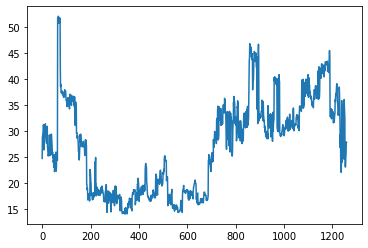

In [75]:
plt.plot(twtr_stock['close'])

前半大きく下り傾向があり、後半から徐々に上がり調子になっていますね。このデータから後に続く30日分のデータを予測することが今回の目標です。

## 予測の手順
---
この予測手法を直感的に説明してしまうと、

1. 時系列データを等間隔でスライドさせながらカーブを切り出して
2. それらを形状の似ているもの同士でグルーピングし
3. 同じグループ内で末尾の株価だけ取り出し、その平均を予測値として扱う

という流れになります。もう少し詳しく説明すると

時系列データから幅(N + K)のスライド窓の作成
スライド窓ごとに平均0、分散1に標準化
スライド窓の手前N個を PCA + k-means でクラスタリング
同クラスタ内で、N+K時点のデータの平均値を計算
cos類似度で近傍クラスタを求め、そのクラスタの平均値を予測に使う
という手順になります。

## 1. 時系列データからスライド窓の作成
---
スライド窓とは、時系列データから一定の幅で1時点ずつスライドさせながら取り出して作るカーブのことです。下図がそのイメージになります。

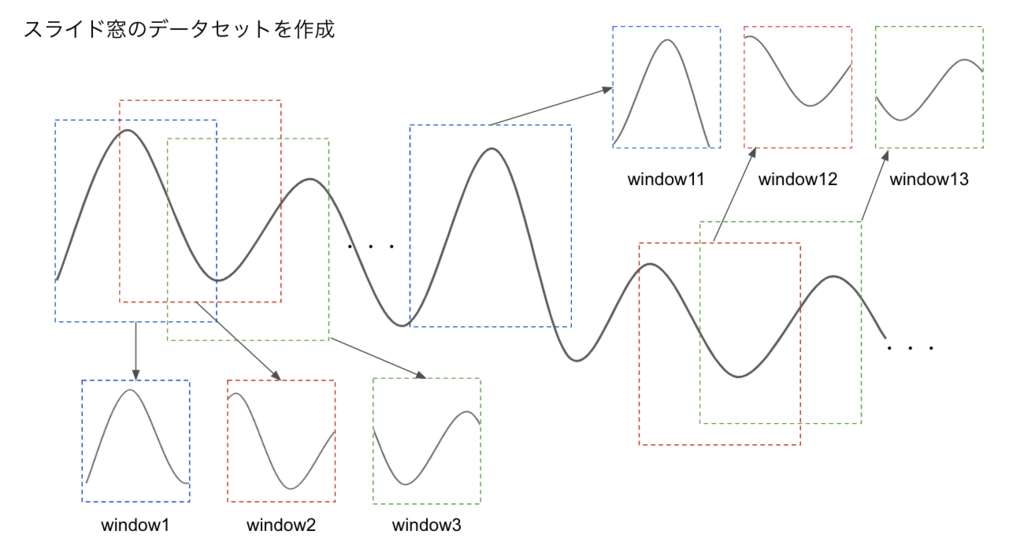

スライド窓、だとわかりにくいので今後はカーブと呼んでしまいます。 ここで作られる複数のカーブを似ているもの同士でまとめ、末尾の値の平均で予測を行います。

今回は直近20日のデータから5日先のデータを予測するとします。（20 + 5）日分のデータで切り出したいので、幅25で1日ごとにスライドさせたデータセットを作成します。

In [88]:
TRAIN_SIZE = 20
TARGET_FUTURE = 5
WINDOW_SIZE =  TRAIN_SIZE + TARGET_FUTURE

def split_window_data(array, window_size):
    length = array.shape[0]
    roop_num = length - window_size + 1
    window_data = np.stack([
        np.hstack(
            np.array(array[i: i+window_size].astype('float64')).reshape(window_size, 1)
        )
        for i in range(roop_num)
    ])
    return window_data

train_close = np.array(train_df['close'])
window_data = split_window_data(train_close, WINDOW_SIZE)

## 2. カーブごとに標準化
---
カーブごとに切り出したデータは、あるものは（20 30 35 25 30）、別のものは（60 80 70 80 100）だったりとスケールが異なります。この生の値でクラスタリングを行うと、スケールの大きいもの同士でまとまってしまいますが、今回は時系列の形状や特徴が似ているもの同士でまとめる必要があります。

そのためカーブごとに「標準化」という操作を行い、平均0、分散1のスケールを統一してしまいます。

In [89]:
# 標準化
sc = StandardScaler()
window_sc = np.stack([
    np.hstack(sc.fit_transform(vec.reshape(WINDOW_SIZE, 1)))
    for vec in window_data
])

## 3. PCA + k-means でクラスタリング
---
ここからの手順を下図を使って説明します。同じ幅のカーブを冒頭で作成しましたが、今度はこれらを形の似ているもの同士でまとめていきます。

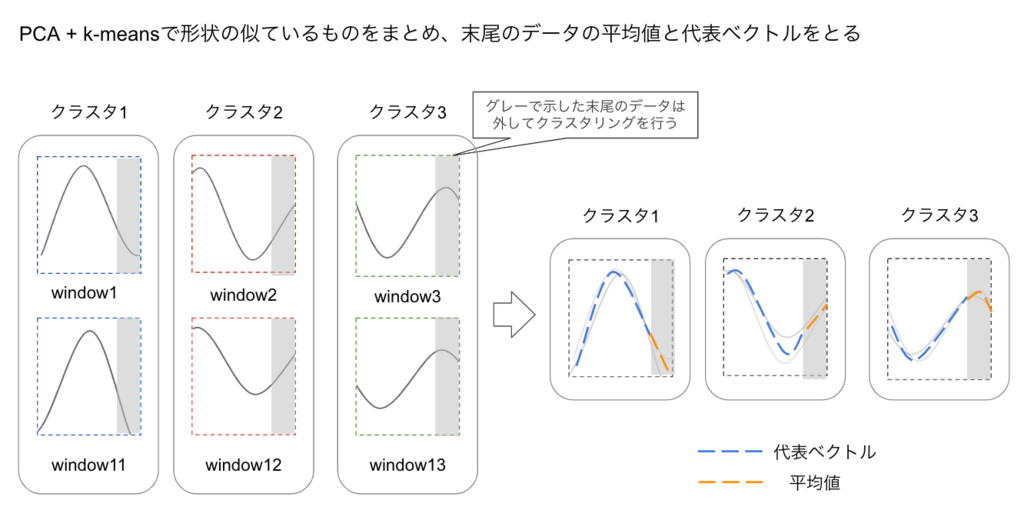

k-meansとはクラスタリングの一つで、数学的に似ている（数学的に距離が近い、と言ったりします）データを任意のグループに分類します。分類後のグループを「クラスタ」、各クラスタの重心に位置するデータを「代表ベクトル」と呼びます。代表ベクトルも後の計算で使うため、ここで算出しておきます。クラスタリングの後、分類時には外していた末尾のデータの平均値を計算します。末尾というのは、今回でいうと25日分のカーブのうち末尾５日分のデータのことです。

細かい話になるので上図には記載しなかったのですが、今回の予測ではPCAという処理を通してからk-meansを実行します。なぜPCAが必要か、については記事末尾の補足にて記載しております。

クラスタリングの実行
それでは、PCA + k-means クラスタリングを行い、クラスタごとの平均値を計算していきます。

In [90]:
def curve_clustering(array, curve_len):
    train = np.stack([vec[0:curve_len] for vec in array])
    test = np.stack([vec[curve_len:] for vec in array])
    test_len = test.shape[1]
    
    # PCA
    pca = PCA(n_components=curve_len)
    pca.fit(train)
    
    # 共分散行列から写像
    cov_mtrx = pca.get_covariance()
    train_pca = np.dot(train, cov_mtrx)
    
    # あとで元に戻すため、共分散行列の逆行列を求めておく
    cov_mtrx_inverse = np.linalg.inv(cov_mtrx)

    # k-meansクラスタリング
    curve_clst_size = int(np.sqrt(train_pca.shape[0]/2))
    cls = KMeans(n_clusters=curve_clst_size, random_state=123)
    curve_clst = cls.fit_predict(train_pca)
    
    # クラスタ毎に、カーブのリスト、平均、分散、代表ベクトルを求めておく
    curve_df = pd.DataFrame({
        'curve_clst': curve_clst
        , 'train': [vec for vec in train]
        , 'train_pca': [vec for vec in train_pca]
    })
    for i in range(test_len):
        curve_df['test{}'.format(i)] = [vec[i] for vec in test]
    print([col for col in curve_df.columns if 'test' in col])
    curve_clst_dict = {
        cluster : {
            'test_means': [df[col].mean() for col in df.columns if 'test' in col]
            , 'test_medians': [df[col].median() for col in df.columns if 'test' in col]
            , 'test_stds': [df[col].std() for col in df.columns if 'test' in col]
            , 'train_cluster_center': np.dot(cls.cluster_centers_[cluster].flatten(), cov_mtrx_inverse)
            , 'train_pca_cluster_center': cls.cluster_centers_[cluster].flatten()
            , 'train_vectors': [vec for vec in df['train']]
            , 'train_pca_vectors': [vec for vec in df['train_pca']]
        }
        for cluster, df in curve_df.groupby('curve_clst')
    }
    return (curve_clst_dict, cls, pca)

curve_clst_dict, cls, pca = curve_clustering(window_sc, TRAIN_SIZE)

['test0', 'test1', 'test2', 'test3', 'test4']


ここではクラスタ数を

curve_clst_size = int(np.sqrt(train_pca.shape[0]/2))
と決めていますが、理由は記事末尾の補足に少しだけ記載しております。

クラスタリングの結果の可視化
それらしい分類になっているか、クラスタ毎のカーブをまとめてプロットしていきます

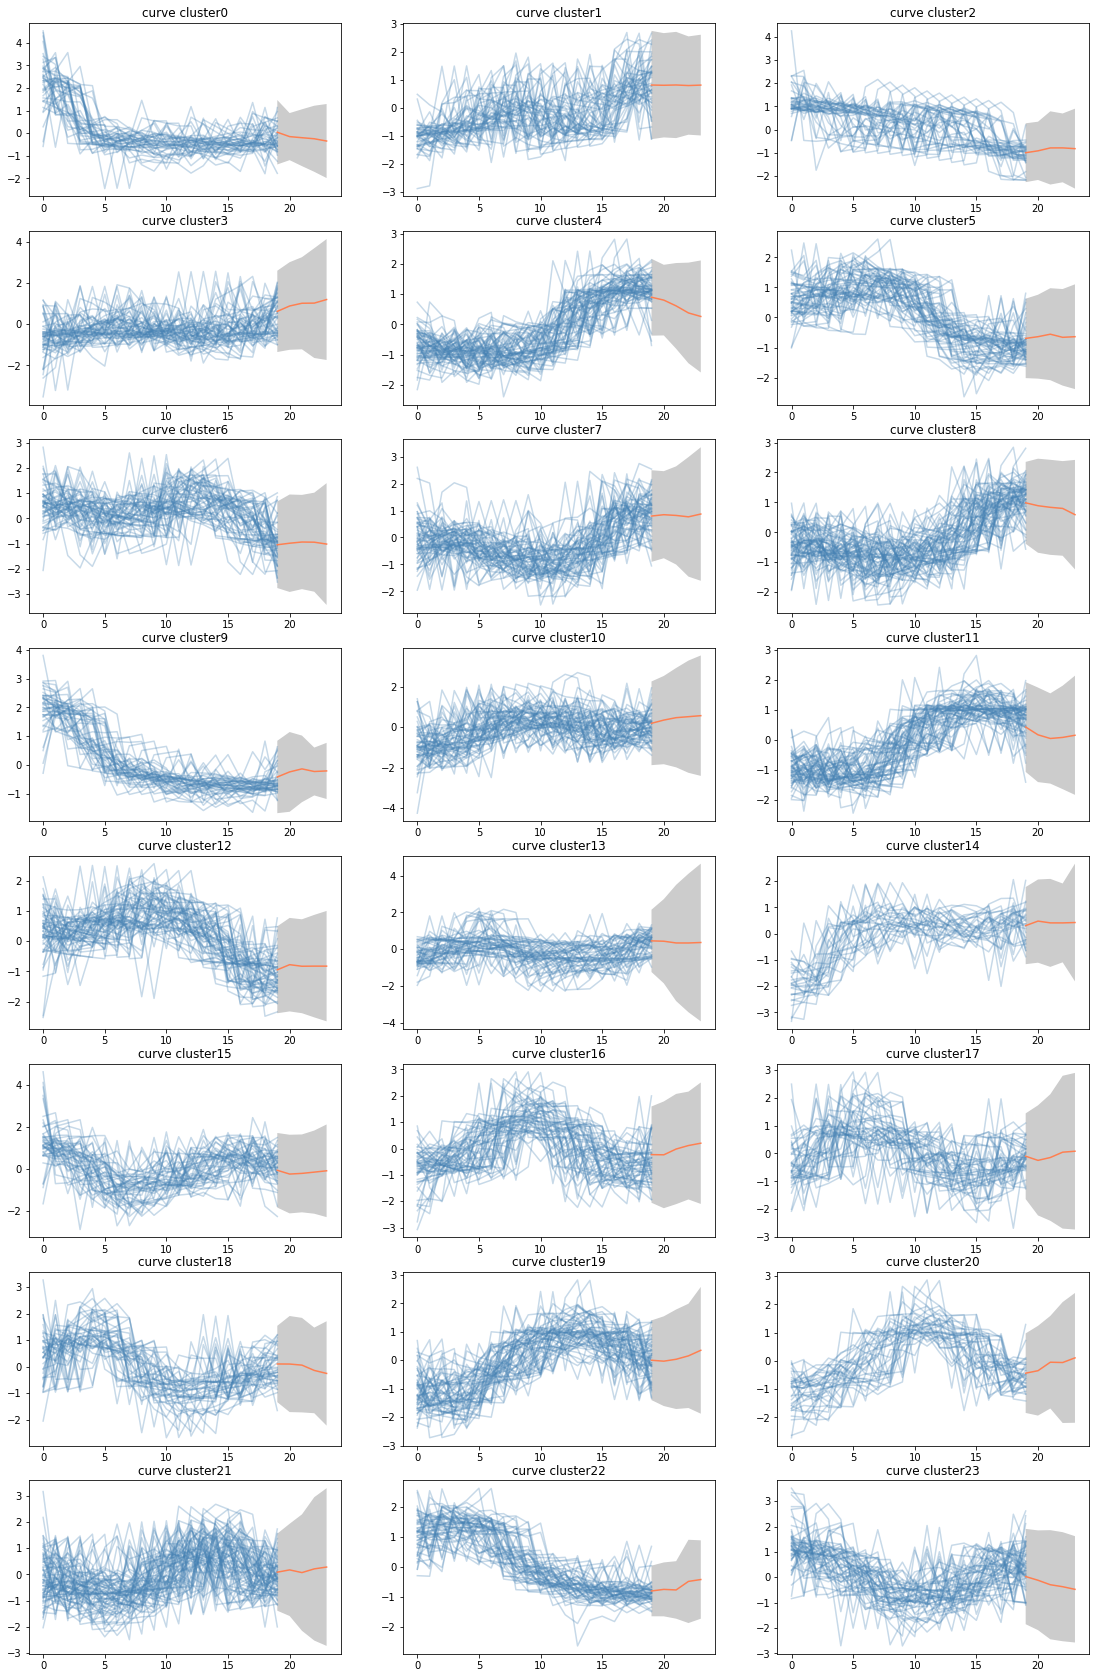

In [91]:
# グラフを行列形式で表示する
clst_size = len(curve_clst_dict)
row_size = int(clst_size/3) if clst_size%3 == 0 else int(clst_size/3) + 1
x_axis = [x for x in range(WINDOW_SIZE - 1)]

fig = plt.figure(figsize=(19,30))
for key in curve_clst_dict:
    # カーブのリストを取り出す
    clst_info = curve_clst_dict[key]
    raw_curves = clst_info['train_vectors']
    
    # subplotと行列番号の設定
    row_n = int(key/3)
    col_n = key%3
    ax = plt.subplot2grid((row_size,3), (row_n, col_n))
    
    # カーブのプロット
    for raw_curve in raw_curves:
        ax.plot(raw_curve, color='steelblue', alpha=0.3)
        
    # 区間のプロット
    upper_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) + 2*np.array(clst_info['test_stds'])])
    lower_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) - 2*np.array(clst_info['test_stds'])])
    ax.fill_between(x_axis, upper_95, lower_95, facecolor='gray', alpha=0.4)
    
    # 平均値のプロット
    ax.plot(list(np.repeat(np.nan, TRAIN_SIZE-1)) + list(clst_info['test_means']), color='coral')
    ax.set_title('curve cluster{}'.format(key))
plt.show()

（本当はクラスタ23まであるのですが、長い上に結論も変わらないのでクラスタ8まで載せています。） 青色の線がカーブの集まりです。一つのクラスタを注視すると、変動の大きいカーブと小さいカーブが混在しつつも、大まかなトレンドは同一であると分かります。

オレンジの線がクラスタリングに使わなかったデータの平均値です。グレーは （平均 ± 2 * 標準偏差）の範囲を表しています。やや分散の大きいクラスタが多い印象です。

## 4. cos類似度で近傍クラスタを求める
---
ここからの手順を下図を使って説明します。今度は、未知データがどのクラスタに近いかをcos類似度を用いて探します。

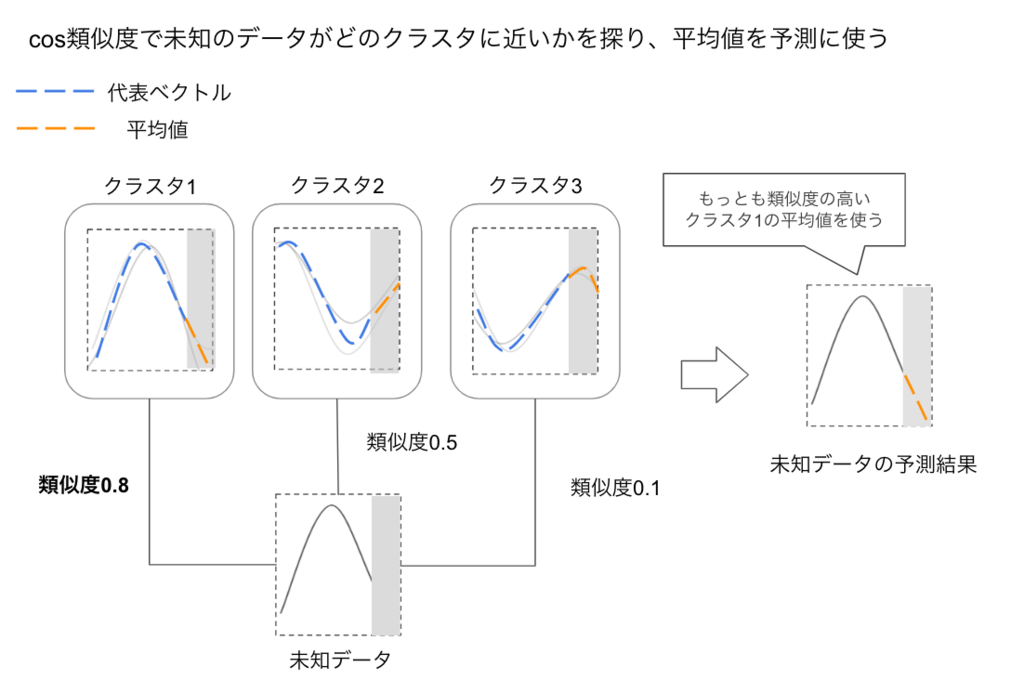

cos類似度とは、2つのベクトル（ここではカーブのこと）の類似度を測る指標です。上の図中では未知データのカーブと、各クラスタの代表ベクトル（青色の点線）を比較し類似度を計算しています。クラスタ1との類似度が高いと判定され、未知データのカーブの先に、クラスタ1の平均値（オレンジの点線）を当てはめて予測値としています。

それでは実際のデータで実行していきます。

最近傍のクラスタを見つける
下記のコードでは、2018年11月以前のデータを再びスライド窓に分割し、標準化しています。各クラスタの代表ベクトルとの類似度を求めるため、切り出す幅がTRAIN_SIZEになっている点が冒頭と異なります。

In [92]:
# TRAIN_SIZEで分割
window_data_train = split_window_data(train_close, TRAIN_SIZE)

# 標準化
sc = StandardScaler()
window_sc_train = sc.fit_transform(window_data_train.T).T

次に切り出したカーブのベクトルと、各クラスタの代表ベクトルの類似度を計算し、もっとも類似度が高いクラスタの番号を返す関数を作ります。

In [93]:
# cos類似度を計算する関数
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# もっとも類似度の高いクラスタの番号を返す関数
def calculate_neighbor_clst(window_vec, curve_dict):
    cos_sim_vec = np.array([
       cos_sim(window_vec, curve_clst_dict[clst]['train_cluster_center'])
       for clst in curve_clst_dict
   ])
    return cos_sim_vec.argmax()

最近傍クラスタから平均値の取り出し
続いて、最近傍クラスタの平均値を取り出します。取り出したらスケールを戻して予測値とします。

In [94]:
# もっとも近いクラスタの平均値を取り出す
scaled_means = []
for vec in window_sc_train:
    neighbor_clst = calculate_neighbor_clst(vec, curve_clst_dict)
    scaled_mean = np.array(curve_clst_dict[neighbor_clst]['test_means'][TARGET_FUTURE - 1])
    scaled_means.append(scaled_mean)
    
# 取り出した平均値を元のスケールに戻す
scaled_means = np.array(scaled_means)
pred_means = sc.inverse_transform(scaled_means)

以上で予測値を算出するところまでは完了です。次の節で予測がどれくらい当たってたのかを検証していきます。

## 5. 予測結果の評価
---
予測結果と実際の値をプロットしてみましょう。

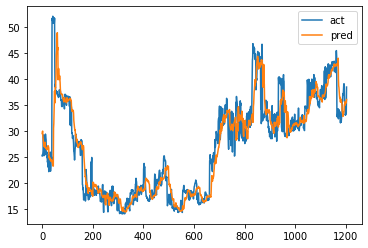

In [95]:
act = train_close[WINDOW_SIZE:]
pred = pred_means[0:-TARGET_FUTURE-1].flatten().tolist()
plt.plot(act, label='act')
plt.plot(pred, label='pred')
plt.legend()

青色が実測値、オレンジが予測値です。すごく当たっているように見えますが、実は数日前のラグを取ったような予測になっています。これでは予測できたと言えません。

## 株価の「上昇する」か「下落する」かの予測

今回は直近20日のデータから5日先のデータを予測する、というテーマだったので、20日目の株価から５日先の株価が上がっているか、下がっているかの判定をしてみましょう。

In [96]:
# 20日目の株価と５日後の実際の株価を比べ、上がってるor下がってるか
act_updown = [
    train_close[i + WINDOW_SIZE] > train_close[i + TRAIN_SIZE] 
    for i in range(len(train_close) - WINDOW_SIZE)
]
# 20日目の株価と５日後の予測株価を比べ、上がってるor下がってるか
pred_updown = [
    pred[i] > train_close[i + TARGET_FUTURE]
    for i in range(len(train_close) - WINDOW_SIZE)
]

最初のact_updownには20日目と比較して５日後の実際の株価が上がったか、下がったかの真偽値を格納しています。次のpred_updownには５日後の予測の株価と比較した結果が入っています。この予想結果の正答率を計算していきます。

In [97]:
TF = (np.array(act_updown) == np.array(pred_updown))
sum(TF)/len(TF)

0.48172757475083056

結果は48.2% でした！シンプルに株価の上下を予想してもほとんど当たってないですね笑

## 検証データと予測値の比較


今度は冒頭のほうで検証用に残していた、2018年11月以降の30日分の株価を予測してみましょう。 30日分の予測なので、ひとつずつ予測値をカーブに追加していきながら、最終的には20個の予測値を使って30日先の株価を予測することになります。

In [98]:
# スライド窓から予測値を算出する関数
def predict_(window_vec, target_future):
    test_sc = StandardScaler()
    vec_sc = test_sc.fit_transform(window_vec.reshape(TRAIN_SIZE, 1)).T
    neighbor_clst = calculate_neighbor_clst(vec_sc, curve_clst_dict)
    scaled_mean = np.array(curve_clst_dict[neighbor_clst]['test_means'][target_future]).reshape(-1, 1)
    return test_sc.inverse_transform(scaled_mean.reshape(-1,1))

# 予測値を追加しながら、次点の値を予測
def predict_forward(window_vec, n_forward, target_future):
    predictions = []
    vec_len = window_vec.shape[0]
    train_vec = window_vec.copy()
    for _ in range(n_forward):
        pred = predict_(train_vec, target_future).flatten()
        predictions.append(pred[0])
        train_vec = np.append(train_vec[-vec_len + 1:], pred)
    return predictions 

# テストデータの長さ分の予測値を算出
test_len = len(test_df)
last_window = window_data_train[-1]
predictions = predict_forward(last_window, test_len, TARGET_FUTURE-1)

この予測を重ねた結果と、30日分の実測値をプロットした結果が下記となります。

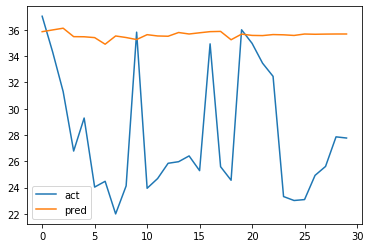

In [99]:
plt.plot(test_df['close'], label='act')
plt.plot(predictions, label='pred')
plt.legend()

青色が実測値、オレンジの線が予測値です。実測値より予測値はなだらかな線になっています。やはり予測値を平均で代用しているので、変動の大きい時系列を捉えるのは不得意そうですね。

## まとめ

株価を使う時点で予想してはいましたが、さっぱりうまくいきませんでした。この手法を教えてくれた人は「これで為替レートの予測がうまくいった！」と言っていたので、万に一つの可能性があって株の予想ができたら、、、と思いましたが現実は厳しいですね。

これの使いどころとしては、クラスタ毎にまとめた平均値、つまりノイズを省いたトレンドを検出できるので、下記のケースなら有効かもしれません。

局面変化の検知
長期ではなく短期の予測
件数の少ない時系列データに対し、傾向の似ている別の時系列データから予測値を算出
以上が、私の記憶と数少ない資料を頼りに再現した予想手法でした。これを読まれたどなたかが、「その分析知ってるけど使い方違うよ！」などご指摘くだされば何よりです。

明日はデザイナーの小山さんです！お楽しみに！